In [5]:
import numpy as np
from sklearn import linear_model, svm
from sklearn import isotonic
import networkx as nx
import math
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

In [6]:
datas = ['Colors', 'Time Taken', 'Iterations Taken']
data_X = []
data_y = {}
ends = ['chi500', 'chi1000', 'testset', 'dimacs']
ends_y = ['chi500', 'chi1000', 'testset_fixed', 'dimacs_fixed']
stemX = 'C:/Users/pov_p/OneDrive - UC San Diego/Classes/CSE 291F/project/Data/clique_measurements/'
stem_y = 'C:/Users/pov_p/OneDrive - UC San Diego/Classes/CSE 291F/project/Code/readymade_heuristics/gCol/measurements/'
algs = ['AntCol', 'BacktrackingDSatur', 'HillClimber', 'HybridEA', 'PartialColAndTabuCol', 'RLF', 'SimpleGreedy']

In [7]:
import scipy.stats
import statistics
def parse_degree_data(g: nx.Graph) -> list:
    degrees = [v[1] for v in g.degree]
    minimum = min(degrees)
    maximum = max(degrees)
    median = statistics.median(degrees)
    entropy = scipy.stats.entropy(degrees)
    q1, q3 = np.quantile(degrees, [.25, .75])
    var_coef = scipy.stats.variation(degrees)
    avg = statistics.mean(degrees)
    return [minimum, maximum, avg, median, q1, q3, var_coef, entropy]

degree_X = []
basic_X = []

def parseGraph(filename):
    # So first we have to cull the thing
    G = nx.Graph()

    f = open(filename)
    for line in f:
        if line[0] == 'c':
            continue
        elif line[0] == 'p':
            x = line.split()
            G.add_nodes_from(range(1, int(x[2])))
        elif line[0] == 'e':
            x = line.split()
            G.add_edge(int(x[1]) - 1, int(x[2]) - 1)
    f.close()
    return G

datasets = ['chi500', 'chi1000', 'dimacs_fixed', 'testset_fixed']#['chi1000', 'chi500', 'dimacs_fixed', 'testset_fixed']
for curr_dataset in datasets:
    #if alg == 'AntCol' and curr_dataset == 'chi500': continue

    stem = './Data/'#'../../../Data/'
    graphsToUse = []
    graphFile = open(str(stem + curr_dataset + '_list.txt'))
    for line in graphFile:
        graphsToUse.append(line.strip())
    graphFile.close()

    
    for graph in tqdm(graphsToUse, 'Running on ' + curr_dataset):
         g = parseGraph(stem + curr_dataset + '/' + graph)
         degree_X.append(parse_degree_data(g))

len(degree_X)

In [8]:
"""
data_X = []
data_y_colors = []
data_y_dsatur_colors = []
data_y_improvement = []
data_y_runtime = []
"""


for e in tqdm(ends):
    f_X = open(stemX + e + '_X')
    for line in f_X:
        line = line.strip()
        arr = line.strip('][').split(', ')
        #print(arr)
        toAppend = list(map(float, arr))
        toAppend[5] /= (10 ** 9)
        data_X.append(toAppend)
    f_X.close()
for alg in algs:
    data_y[alg] = {
        'Colors': [],
        'Time Taken': [],
        'Iterations Taken': []
    }
    for e in tqdm(ends_y, ):
        f_y = open(stem_y + alg + '/'+ e + '_y')
        f_y.readline()
        for line in f_y:
            s_arr = list(line.strip().strip('][').split(', '))
            if list(s_arr[0]):
                arr = list(map(int, s_arr))
            else:
                arr = [-1, -1, -1]
            data_y[alg]['Colors'].append(arr[0])
            data_y[alg]['Time Taken'].append(arr[1])
            data_y[alg]['Iterations Taken'].append(arr[2])
            
            """
            # Mark all the 'None' ones to remove later
            data_y_colors.append(
                -1 if arr[1] == 'None' else int(arr[1])
            )
            data_y_dsatur_colors.append(
                -1 if arr[0] == 'None' else int(arr[0])
            )
            data_y_improvement.append(
                -1 if (arr[1] == 'None' or arr[0] == 'None') else int(arr[0]) - int(arr[1])
            )
            data_y_runtime.append(
                -1 if arr[2] == 'None' else math.log(float(arr[2]) + 1)
            )"""
        f_y.close()


    """
    f_y = open(stem + e + '_y')
    for line in f_y:
        if int(line.strip()) == 0:
            train_y.append(0)
            continue
        train_y.append(math.log(int(line.strip())))
    f_y.close()
    """


100%|██████████| 4/4 [00:00<00:00, 133.33it/s]


In [10]:
# Clean x
#i = 0
indices = set()
#while i < len(data_X):
for i in range(len(data_X)):
    for alg in algs:
        found = False
        for datum in datas:
            if data_y[alg][datum][i] == -1:
                indices.add(i)
                found = True
                break
        if found: 
            break
for i in sorted(list(indices), reverse=True):
    #degree_X.pop(i)
    data_X.pop(i)
for alg in algs:
    for datum in datas:
        for i in sorted(list(indices), reverse=True):
            data_y[alg][datum].pop(i)
    # Lets just make a set of all of idices, we have to pop
    #if(data_y_runtime[i] == -1 or data_y_colors[i] == -1 or data_y_improvement[i] == -float('inf')):
    #i += 1
#set(data_y_improvement)

In [11]:
print(len(data_X))
print(len(data_y['AntCol']['Colors']))
print(len(data_y['HybridEA']['Colors']))

1613
1613
1613


In [12]:
r = list(range(len(data_X)))
random.seed(1)
random.shuffle(r)
train_X = []
train_y = {}
test_X = []
test_y = {}

for alg in algs:
    test_y[alg] = defaultdict(list)
    train_y[alg] = defaultdict(list)

for p in tqdm(r):
    if random.random() < .25:
        test_X.append(data_X[p])
        toAdd = test_y
    else:
        train_X.append(data_X[p])
        toAdd = train_y
    for alg in algs:
        for datum in datas:
            toAdd[alg][datum].append(data_y[alg][datum][p])

100%|██████████| 1613/1613 [00:00<00:00, 73390.31it/s]


In [13]:
print(len(train_y['AntCol']['Colors']))
print(len(train_X))

1213
1213


In [14]:
def predict_and_plot(mod, test_X, test_y, t, alg, measurement):
    predictions = mod.predict(test_X)
    # Not long anymore for now
    plt.plot(predictions, test_y, 'o', label = '(log(predicted), log(true))')
    plt.ylabel('log(True {})'.format(t))
    plt.xlabel('log(Predicted {})'.format(t))
    plt.title(alg + ' ' + measurement)
    right = int(max(max(test_y), max(predictions))) + 2
    left = int(min(min(test_y), min(predictions)))
    return plt.plot(range(left, right), range(left, right), label = 'Perfect Prediction')

In [15]:
from sklearn.ensemble import RandomForestRegressor
m = RandomForestRegressor()

In [16]:
import copy
df_test = pd.DataFrame({
    'alg': [],
    'Colors': [],
    'Time Taken': [],
    'Iterations Taken': []
})
df_train = pd.DataFrame({
    'alg': [],
    'Colors': [],
    'Time Taken': [],
    'Iterations Taken': []
})
i = 0
for alg in algs:
    curr = test_y if i == 0 else train_y
    #m.fit()
    temp = pd.DataFrame(curr[alg])
    temp['alg'] = alg
    df_test = df_test.append(copy.deepcopy(temp))
df_test = df_test.set_index('alg')
i = 1
for alg in algs:
    curr = test_y if i == 0 else train_y
    #m.fit()
    temp = pd.DataFrame(curr[alg])
    temp['alg'] = alg
    df_train = df_train.append(copy.deepcopy(temp))
df_train = df_train.set_index('alg')
#df.xs(('AntCol', 'Test'), level=('alg', 'dataset'))
#df.loc['AntCol', 'colors']

In [17]:
df_train

,Colors,Time Taken,Iterations Taken
alg,,,
AntCol,109.0,825.0,85024176.0
AntCol,116.0,345.0,99631166.0
AntCol,63.0,463.0,69991945.0
AntCol,175.0,816.0,84013749.0
AntCol,170.0,717.0,82579529.0
...,...,...,...
SimpleGreedy,142.0,0.0,61006.0
SimpleGreedy,115.0,0.0,156732.0
SimpleGreedy,10.0,0.0,33210.0


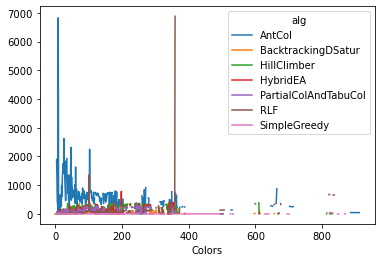

In [44]:
#df_train.index
#df_train.reset_index()
#df_train.reset_index().pivot_table(index='Colors', columns='alg', values='Time Taken').plot()

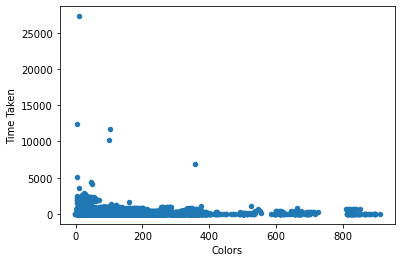

In [27]:
#[x[1] for x in list(df_train.loc['AntCol', 'Colors'].items())]
#df_train.plot(x='Colors', y='Time Taken', kind = 'scatter')

In [18]:
scores = {}
for datum in datas:
    train_preds = []
    test_preds = []
    alg_scores = {}
    for alg in algs:
        # Train the regressor
        m.fit(train_X, train_y[alg][datum])


        # Predict train and append
        train_preds.extend(m.predict(train_X))#, train_y[alg][datum]))
        test_preds.extend(m.predict(test_X))#, test_y[alg][datum]))
        #print(alg, datum, m.score(test_X, test_y[alg][datum]), m.feature_importances_)
        #plots.append(predict_and_plot(m, test_X, test_y[alg][datum], datum, alg, datum))
        alg_scores[alg] = m.score(test_X, test_y[alg][datum])
    scores[datum] = alg_scores
    print(len(test_preds))
    df_test[datum + '_hat'] = test_preds
    df_train[datum + '_hat'] = train_preds

2800
2800
2800


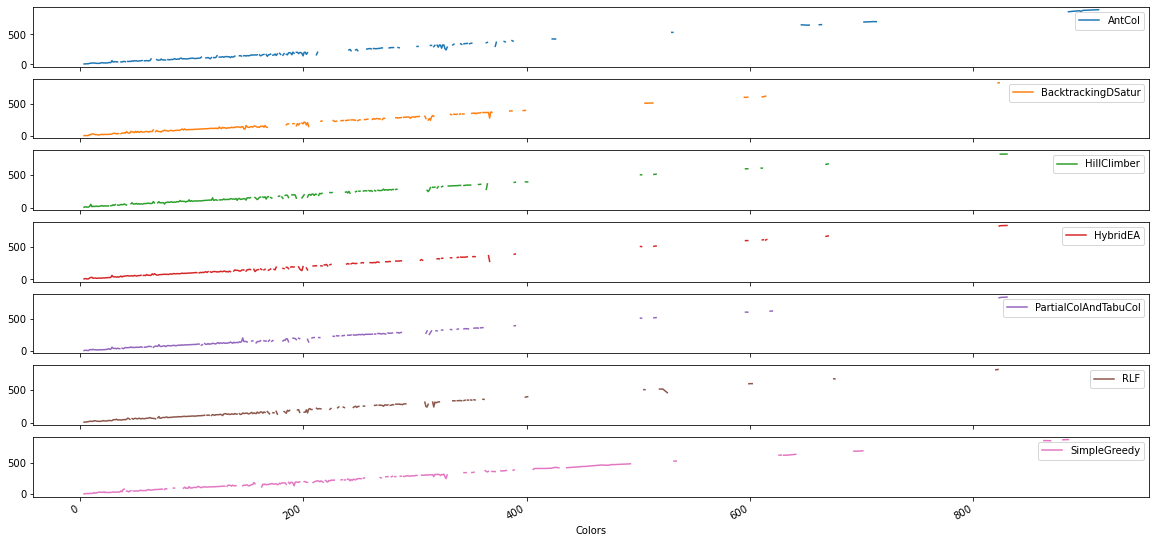

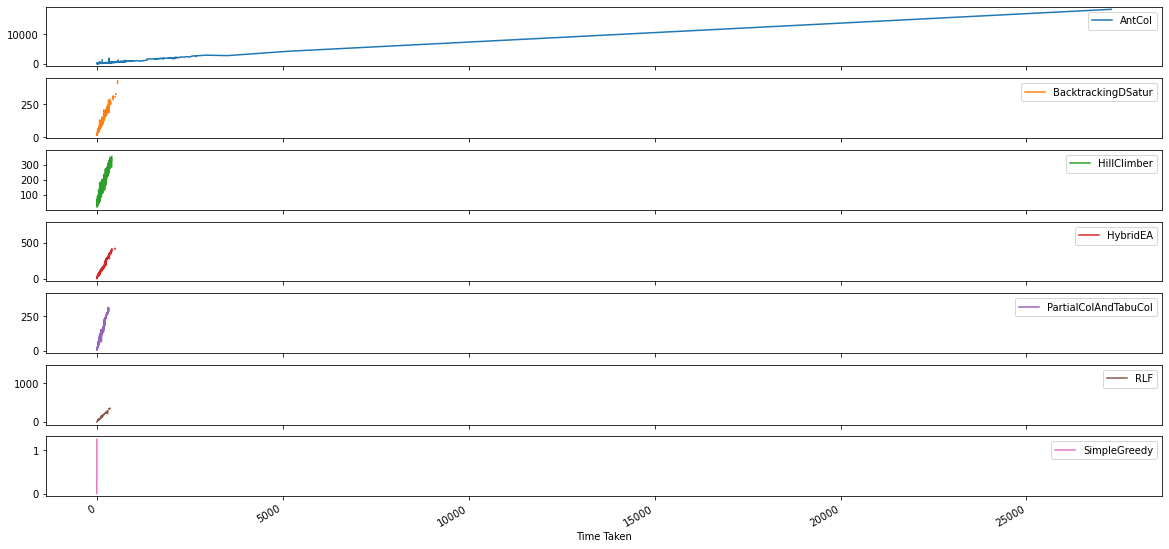

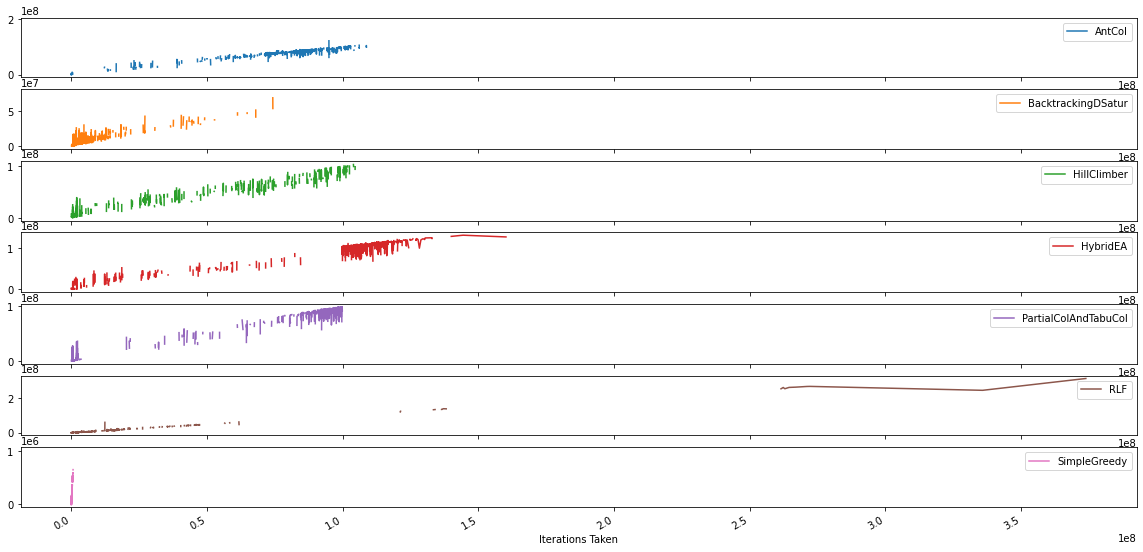

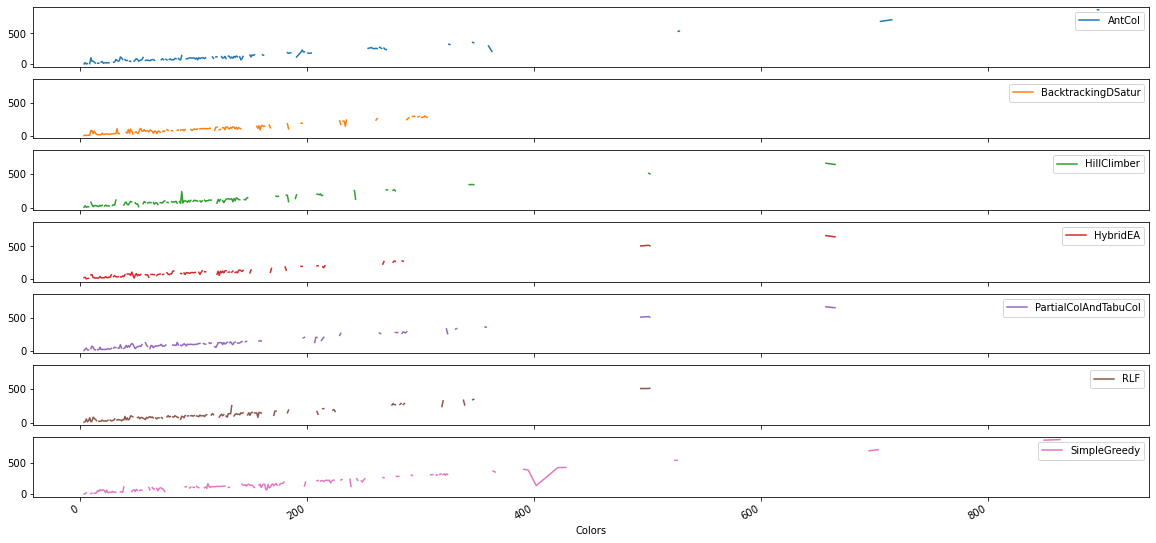

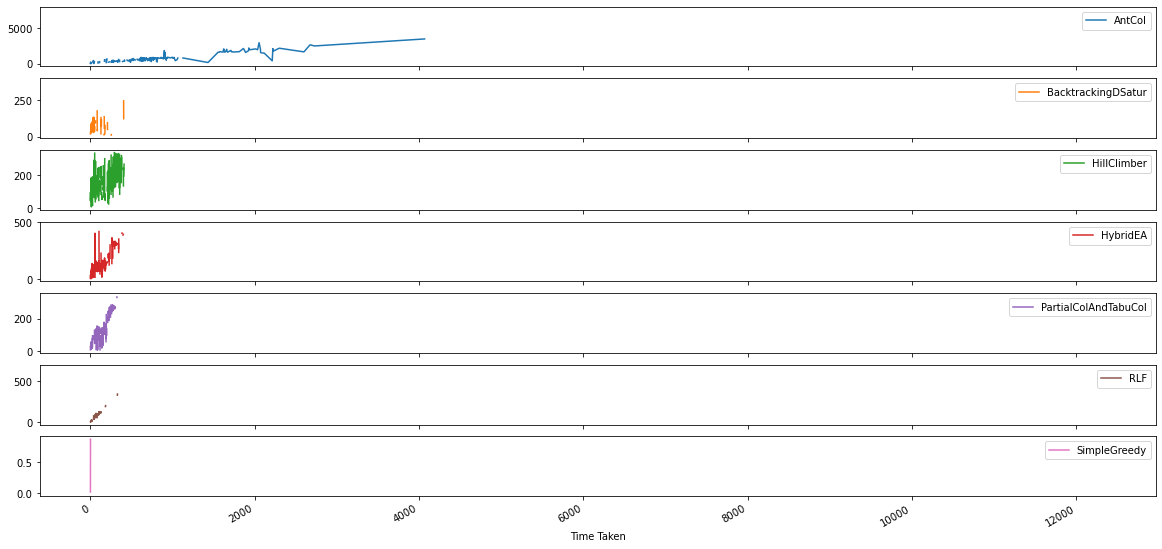

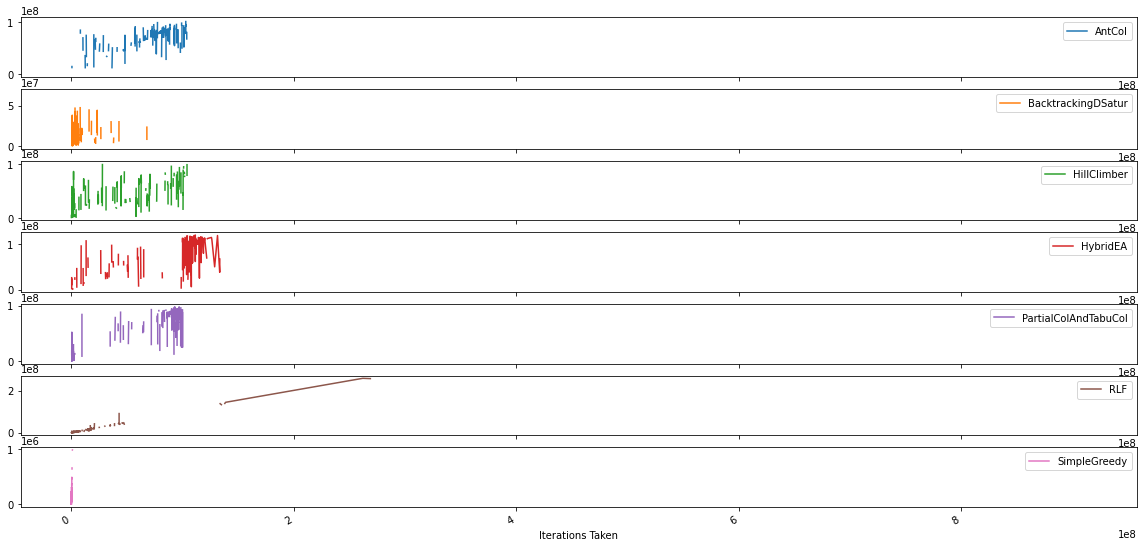

In [19]:
for df in [df_train, df_test]:
    for datum in datas:
        df.reset_index().pivot_table(index=datum, columns='alg', values=datum + '_hat').plot(figsize = (20, 10), subplots = True)

In [20]:
results = defaultdict(list)
for alg in algs:
    for datum in datas:
        # Train the regressor
        m.fit(train_X, train_y[alg][datum])

        # Add to data
        results['Algorithm'].append(alg)
        results['Metric'].append(datum)
        results['Score'].append(m.score(test_X, test_y[alg][datum]))
        #results[(alg, datum)]
        #print(alg, datum, m.score(test_X, test_y[alg][datum]), m.feature_importances_)
        #print(predict_and_plot(m, test_X, test_y[alg][datum], datum, alg, datum))

In [21]:
results_df = pd.DataFrame(results)

In [27]:
results_df.set_index(['Metric']).sort_index()

Score
Algorithm            Metric                    
AntCol               Colors            0.946028
                     Iterations Taken  0.534990
                     Time Taken        0.843821
BacktrackingDSatur   Colors            0.933790
                     Iterations Taken -0.075025
                     Time Taken       -0.073830
HillClimber          Colors            0.935343
                     Iterations Taken  0.294371
                     Time Taken        0.328279
HybridEA             Colors            0.934499
                     Iterations Taken  0.574186
                     Time Taken        0.718332
PartialColAndTabuCol Colors            0.941095
                     Iterations Taken  0.746359
                     Time Taken        0.843732
RLF                  Colors            0.934328
                     Iterations Taken  0.444127
                     Time Taken        0.178305
SimpleGreedy         Colors            0.936742
                     Iterations Taken  0.711832
                     Time Taken       -0.003823

0.8711898469708452
[0.05405379 0.03343424 0.04774096 0.08449642 0.06779662 0.56410588
 0.14837209]


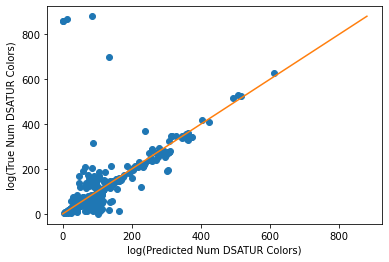

In [8]:
model = m.fit(train_X, train_y_dsatur_colors)
print(model.score(test_X, test_y_dsatur_colors))
print(model.feature_importances_)
#print(model.coef_ + [model.intercept_])
predict_and_plot(model, test_X, test_y_colors, 'Num DSATUR Colors')

0.9214289989877551
[0.03264136 0.0176751  0.02041    0.04691276 0.0309051  0.22456379
 0.62689188]


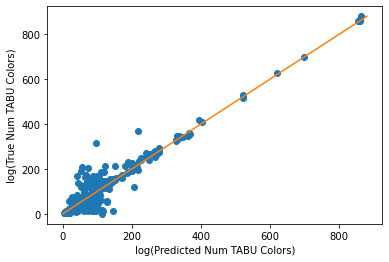

In [9]:
model = m.fit(train_X, train_y_colors)
print(model.score(test_X, test_y_colors))
print(model.feature_importances_)
#print(model.coef_ + [model.intercept_])
predict_and_plot(model, test_X, test_y_colors, 'Num TABU Colors')

0.9834861011509043
[0.02157844 0.00238523 0.00500813 0.00455583 0.02817621 0.03135533
 0.90694084]


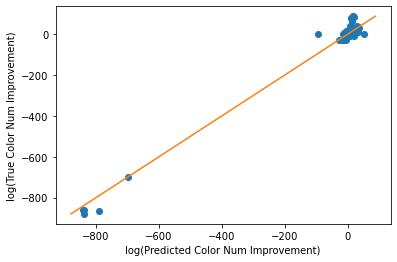

In [10]:
model = m.fit(train_X, train_y_improvement)
print(model.score(test_X, test_y_improvement))
print(model.feature_importances_)
predict_and_plot(model, test_X, test_y_improvement, 'Color Num Improvement')

0.6563936473140373
[0.02977503 0.03533837 0.02181896 0.12103546 0.16991752 0.10478332
 0.51733133]


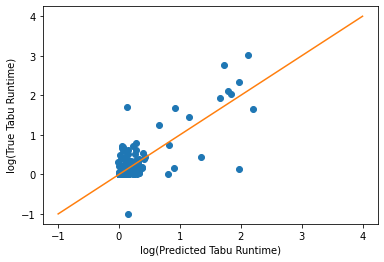

In [11]:
model = m.fit(train_X, train_y_runtime)
print(model.score(test_X, test_y_runtime))
print(model.feature_importances_)
predict_and_plot(model, test_X, test_y_runtime, 'Tabu Runtime')